In [4]:
import pandas as pd 
import psycopg2
import matplotlib.pyplot as plt

### Funzioni per connettere il database e trasformarlo in un DataFrame pandas:


In [5]:
def connect(params_dic):
    """ Per connettersi al database PostgreSQL """
    conn = None
    try:
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn



def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Trasforma una query SELECT in un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Otteniamo una lista di tuple
    tupples = cursor.fetchall()
    cursor.close()
    
    # Convertiamo la lista di tuple in un DataFrame pandas
    df = pd.DataFrame(tupples, columns=column_names)
    return df


Connessione al database:

In [84]:
param_dic = {
    "host"      : "localhost",
    "database"  : "gisa",
    "user"      : "postgres",
    "password"  : "12345"
}

conn = connect(param_dic)

Connecting to the PostgreSQL database...
Connection successful


Conversione in un Pandas dataframe: 

In [85]:
column_names = ["id_controllo","id_stabilimento","riferimento_nome_tab","id_asl","comune","provincia_stab","data_inizio_attivita","macroarea","aggregazione","attivita","tipo_categorizzazione","id_controllo_ultima_categorizzazione","punteggio","data_inizio_controllo","categoria_rischio_stabilimento","categoria_assegnata_da_cu","categoria_ex_ante"]
df = postgresql_to_dataframe(conn,"select * from dataset_clean where lower(provincia_stab) != 'null'",column_names)
df.head()

,id_controllo,id_stabilimento,riferimento_nome_tab,id_asl,comune,provincia_stab,data_inizio_attivita,macroarea,aggregazione,attivita,tipo_categorizzazione,id_controllo_ultima_categorizzazione,punteggio,data_inizio_controllo,categoria_rischio_stabilimento,categoria_assegnata_da_cu,categoria_ex_ante
0,15581,302600,opu_stabilimento,201,BONITO,avellino,2009-12-03 00:00:00,COMMERCIO ALIMENTI USO UMANO,COMMERCIO AL DETTAGLIO DI ALIMENTI E BEVANDE,COMMERCIO AL DETTAGLIO DI ALIMENTI E BEVANDE I...,CATEGORIZZATO DA CU,15581,62,2010-01-15 00:00:00,1,1,2
1,126535,303036,opu_stabilimento,201,ATRIPALDA,avellino,2007-04-24 00:00:00,COMMERCIO ALIMENTI USO UMANO,"COMMERCIO ALL'INGROSSO DI ALIMENTI E BEVANDE, ...",CASH & CARRY,CATEGORIZZATO DA CU,126535,170,2011-07-12 00:00:00,2,2,3
2,22427,36978,organization,206,SAVIANO,napoli,2012-03-22 00:00:00,COMMERCIO ALIMENTI USO UMANO,COMMERCIO AL DETTAGLIO DI ALIMENTI E BEVANDE,COMMERCIO AL DETTAGLIO DI ALIMENTI E BEVANDE I...,CATEGORIZZATO DA CU,819104,59,2010-06-15 00:00:00,1,1,2
3,23072,531077,organization,204,NAPOLI,napoli,2008-03-14 00:00:00,COMMERCIO ALIMENTI USO UMANO,"COMMERCIO ALL'INGROSSO DI ALIMENTI E BEVANDE, ...",CASH & CARRY,CATEGORIZZATO DA CU,682165,315,2010-06-14 00:00:00,2,3,3
4,196788,282868,opu_stabilimento,201,AVELLINO,avellino,2012-07-24 00:00:00,RISTORAZIONE,RISTORAZIONE PUBBLICA,BAR ED ESERCIZI SIMILARI,CATEGORIZZATO DA CU,196788,115,2012-07-24 00:00:00,1,1,2


In [86]:
df["provincia_stab"]= df["provincia_stab"].apply(str.lower)
df.provincia_stab.value_counts()

napoli       32938
salerno      11768
caserta       9859
benevento     5992
avellino      3572
Name: provincia_stab, dtype: int64

Sostituisco i "NULL" con 3

In [141]:
df["categoria_rischio_stabilimento"]= df["categoria_rischio_stabilimento"].replace("NULL",3)
df["punteggio"]= df["punteggio"].replace("NULL",0)
df["categoria_assegnata_da_cu"]= df["categoria_assegnata_da_cu"].replace("NULL",3)
df["categoria_ex_ante"]= df["categoria_ex_ante"].replace("NULL",3)

Rendo i campi numerici, da stringhe a interi

In [142]:
df['categoria_rischio_stabilimento'] = df['categoria_rischio_stabilimento'].astype(int)
df['punteggio'] = df['punteggio'].astype(int)
df['id_asl'] = df['id_asl'].astype(int)
df['categoria_assegnata_da_cu'] = df['categoria_assegnata_da_cu'].astype(int)
df['categoria_ex_ante'] = df['categoria_ex_ante'].astype(int)

In [147]:
province = ["napoli","salerno","caserta","benevento","avellino"]
prov_mean_stab = {}
prov_mean_cu = {}
prov_mean_exante = {}
for prov in province:
    x = round(df.categoria_rischio_stabilimento.loc[df.provincia_stab == prov].mean(),3)
    prov_mean_stab[prov] = x
    
for prov in provincie:
    x = round(df.categoria_assegnata_da_cu.loc[df.provincia_stab == prov].mean(),3)
    prov_mean_cu[prov] = x

for prov in province:
    x = round(df.categoria_ex_ante.loc[df.provincia_stab == prov].mean(),3)
    prov_mean_exante[prov] = x
print("media categoria_rischio_stabilimento: \n",prov_mean_stab,"\n")
print("media categoria_assegnata_da_cu: \n",prov_mean_cu,"\n")
print("media categoria_ex_ante: \n",prov_mean_exante)

media categoria_rischio_stabilimento: 
 {'napoli': 1.639, 'salerno': 2.035, 'caserta': 1.543, 'benevento': 1.699, 'avellino': 1.504} 

media categoria_assegnata_da_cu: 
 {'napoli': 1.641, 'salerno': 2.033, 'caserta': 1.526, 'benevento': 1.707, 'avellino': 1.508} 

media categoria_ex_ante: 
 {'napoli': 2.599, 'salerno': 2.65, 'caserta': 2.55, 'benevento': 2.657, 'avellino': 2.616}


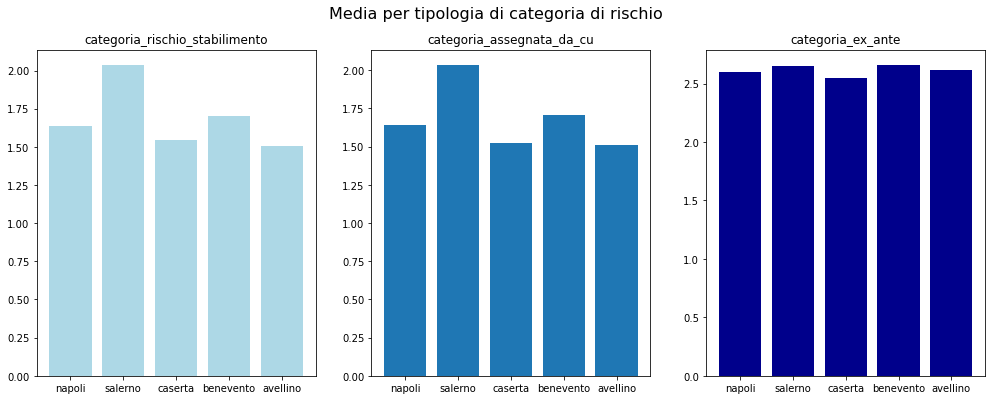

In [149]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (17, 6))
fig.suptitle("Media per tipologia di categoria di rischio", fontsize = 16)

ax1.bar(prov_mean_stab.keys(),prov_mean_stab.values(),color="lightblue")
ax1.set(title="categoria_rischio_stabilimento")

ax2.bar(prov_mean_cu.keys(),prov_mean_cu.values())
ax2.set(title="categoria_assegnata_da_cu")

ax3.bar(prov_mean_exante.keys(),prov_mean_exante.values(),color="darkblue")
ax3.set(title="categoria_ex_ante")

plt.show()

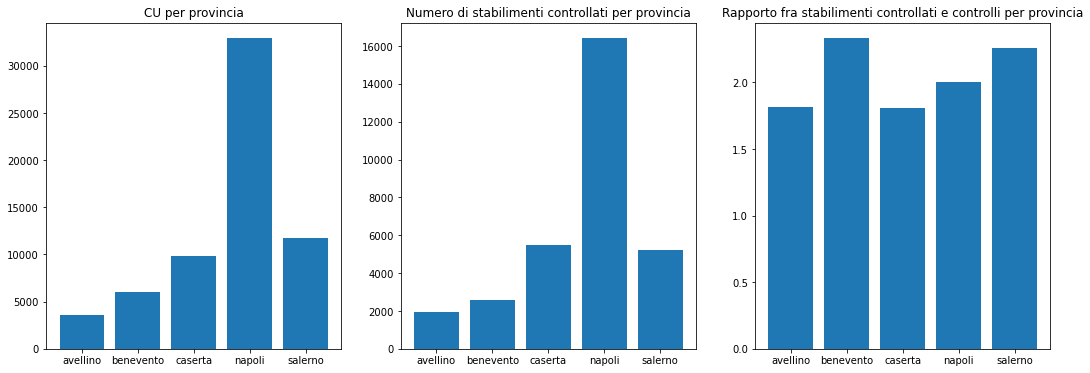


Numero di CU per provincia: 
 {'avellino': 3572, 'benevento': 5992, 'caserta': 9859, 'napoli': 32938, 'salerno': 11768} 


Numero di stabilimenti controllati per provincia: 
 {'avellino': 1968, 'benevento': 2569, 'caserta': 5463, 'napoli': 16417, 'salerno': 5213} 



In [177]:
numero_cu = df.groupby(by="provincia_stab")["id_stabilimento"].describe()["count"]
numero_stab = df.groupby(by="provincia_stab")["id_stabilimento"].describe()["unique"]
cu_per_provincia = {key:value for key,value in numero_cu.items()}
stab_per_provincia = {key:value for key,value in numero_stab.items()}
rapporto_cu_stab = numero_cu/numero_stab 

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (18, 6))

ax1.bar(cu_per_provincia.keys(),cu_per_provincia.values())
ax1.set(title="CU per provincia")

ax2.bar(stab_per_provincia.keys(),stab_per_provincia.values())
ax2.set(title="Numero di stabilimenti controllati per provincia")

ax3.bar(rapporto_cu_stab.keys(),rapporto_cu_stab.values)
ax3.set(title="Rapporto fra stabilimenti controllati e controlli per provincia")
plt.show()
print("\nNumero di CU per provincia: \n",cu_per_provincia,"\n")
print("\nNumero di stabilimenti controllati per provincia: \n",stab_per_provincia,"\n")